<a href="https://colab.research.google.com/github/Chandramani05/Hunting-for-Exoplanet-in-Deep-Space/blob/main/MSML_603_Exoplanet_Detection_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install eli5
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importing Libraries

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from scikeras.wrappers import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

#Loading the Dataset

In [35]:
df = pd.read_csv("/content/drive/MyDrive/Kepler Exoplanet/data/Cleaned Kepler Data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9199, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [36]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

#Data Preprocessing

In [55]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [38]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [39]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

##Scaling the DataSet

In [40]:
X = StandardScaler().fit_transform(X)
X = PCA(n_components=19).fit_transform(X)

##Splitting The Dataset

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

##Hyperparamters for Neural Network

In [50]:
def createModel():
    model = Sequential([
                    Dense(256, activation = 'relu', input_dim=19),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    return model

In [43]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

##Evaluating the Neual Network

In [44]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=20,verbose = 0)
    pred = model.predict(X_test)
    prediction = np.around(pred)
    f1 = f1_score(y_test, prediction)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1


def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [21]:
crossValidation(K=10)

22/22 [==============================] - 0s 2ms/step
F1 Score in fold 1 = 0.9755011135857461
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 2 = 0.9739130434782609
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 3 = 0.9816513761467889
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 4 = 0.9719222462203022
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 5 = 0.9826839826839826
22/22 [==============================] - 0s 1ms/step
F1 Score in fold 6 = 0.975
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 7 = 0.9799554565701559
22/22 [==============================] - 0s 1ms/step
F1 Score in fold 8 = 0.985200845665962
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 9 = 0.9779735682819383
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 10 = 0.9732142857142858
Average 10-Fold F1 Score = 0.9777015918347424

22/22 [=============================

##Testing the Model

In [22]:
model = createModel()
model.fit(X_train, y_train, epochs=40, verbose=1)
pred = model.predict(X_test)
pred = np.around(pred)

Epoch 1/40
176/176 [==============================] - 1s 3ms/step - loss: 0.1134 - binary_accuracy: 0.9649
Epoch 2/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0637 - binary_accuracy: 0.9840
Epoch 3/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0586 - binary_accuracy: 0.9852
Epoch 4/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0524 - binary_accuracy: 0.9868
Epoch 5/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0500 - binary_accuracy: 0.9872
Epoch 6/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0473 - binary_accuracy: 0.9863
Epoch 7/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0452 - binary_accuracy: 0.9879
Epoch 8/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0411 - binary_accuracy: 0.9873
Epoch 9/40
176/176 [==============================] - 1s 3ms/step - loss: 0.0383 - binary_accuracy: 0.9881
Epoch 10/40
176/176 [================

In [23]:
pred

array([[1.5552894e-08],
       [9.9993622e-01],
       [4.1065924e-08],
       ...,
       [6.6725841e-21],
       [3.7211675e-11],
       [9.9999982e-01]], dtype=float32)

In [24]:
pred = pred >= 0.5

In [25]:
performance(y_test, pred)

F1 Score: 0.9802197802197802
Accuracy Score: 0.9837249601441742
Confusion Matrix:
[[939   6]
 [ 12 446]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.99      0.97      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.98      0.99      1403
weighted avg       0.99      0.99      0.99      1403



In [26]:
saveModel(model, "/content/drive/MyDrive/Kepler Exoplanet/model/nn-model.h5")

##Plotting the Feature Importance for Neural Network

In [51]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


In [52]:
eli5.explain_weights(perm, feature_names = TO_USE)

Weight,Feature
0.1534 ± 0.0056,koi_fpflag_nt
0.0622 ± 0.0042,ra
0.0482 ± 0.0053,koi_depth
0.0423 ± 0.0047,koi_srad
0.0369 ± 0.0012,koi_steff
0.0365 ± 0.0032,koi_kepmag
0.0291 ± 0.0036,koi_fpflag_ss
0.0219 ± 0.0012,koi_duration
0.0194 ± 0.0024,dec
0.0192 ± 0.0028,koi_fpflag_co


In [53]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

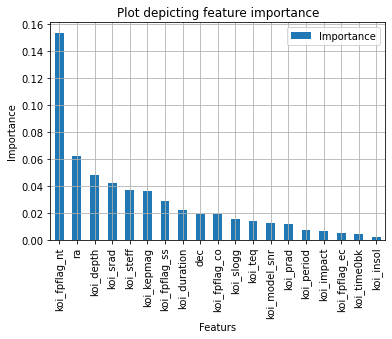

In [54]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Featurs')
plt.ylabel('Importance')
plt.savefig("feat_imp_nn.png", dpi=600)
plt.show()

In [57]:

!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=298d492e317207343cc8eac0838762b409f46e8439a8b63acb306169dde429a5
  Stored in directory: /root/.cache/pip/wheels/4b/ef/77/9b8c4ae2f9a11de19957b80bc5c684accd99114bb8dc6b374c
Successfully built ann-visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from keras.utils.vis_utils import plot_model

In [58]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model, view=True, filename="cconstruct_model", title="NN-model ")